**Toxic Comment Classification -Neural Networks**
- Loading data
- Processing data
- Word-embedding BiLSTM & GRU model:
  - Creating word embeddings
  - Building the model
  - Fitting the model on training data
  - Evaluation of the model using the test data for both BiLSTM and GRU models
- TF-IDF simple Feedforward model
  - Vectorize the data
  - Building simple feed_forward neural networds with adam and rmsprop optimiser
  - Training the model
  - Evaluation of the model

**Loading data**

In [ ]:
# Import the libraries
import pandas as pd
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.models import Sequential
from keras.losses import binary_crossentropy
from tensorflow.keras.layers import Dense, Input, LSTM, Embedding, Dropout, Activation, Bidirectional
from tensorflow.keras.regularizers import l2
import matplotlib.pyplot as plt
from sklearn.metrics import precision_score, recall_score, f1_score
from tensorflow.keras.optimizers import Adam, SGD, RMSprop
from tensorflow.keras.layers import GRU
from sklearn.feature_extraction.text import TfidfVectorizer

In [ ]:
# load both training and test datasets
train = pd.read_csv('ready_train.csv')
test = pd.read_csv('ready_test.csv')

**Processing data and creating word embeddings**

In [ ]:
# Separate feature and labels
X = train['lemmas']
y = train[['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']]
X_test = test['lemmas']
y_test = test[['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']]

In [ ]:
# Define the embedding criteria
word_vector = 100 # size of the word vector
max_features = 6000 # number of unique words
maxlen = 100 # max number of words in one comment
tokenizer = Tokenizer(num_words=max_features)
tokenizer.fit_on_texts(X)

# Covert train and test data into numerial sequence
X_train_sequence = tokenizer.texts_to_sequences(X)
X_test_sequence = tokenizer.texts_to_sequences(X_test)
# Padding sequence to make all sequence have the same shape
X_train = pad_sequences(X_train_sequence, maxlen=maxlen)
X_test = pad_sequences(X_test_sequence, maxlen=maxlen)
word_index = tokenizer.word_index

In [ ]:
# Get GloVe embeddings
def get_coefs(word,*arr):
    return word, np.asarray(arr, dtype='float32')

EMBEDDING_FILE='glove.6B.100d.txt'
embeddings_index = dict(get_coefs(*o.strip().split()) for o in open(EMBEDDING_FILE, encoding="utf8"))

all_embs = list(embeddings_index.values())
emb_mean, emb_std = np.mean(all_embs), np.std(all_embs)
emb_mean, emb_std

word_index = tokenizer.word_index

nb_words = min(max_features, len(word_index))
embedding_matrix = np.random.normal(emb_mean, emb_std, (nb_words, word_vector))

for word, i in word_index.items():
    if i >= max_features:
        continue
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

In [ ]:
# Check embedding shap
embedding_matrix.shape

(6000, 100)

**Define, train, and evaluate BiLSTM with different optimizers**

In [ ]:
# Learning Rate Scheduling
learning_rate = 0.000001
adam_epsilon = 1e-7

lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=learning_rate,
    decay_steps=1000,
    decay_rate=0.95,
    staircase=True
)

In [ ]:
def train_model(optimizer, X_train, y, validation_split=0.2, batch_size=64, epochs=10):
    # Create a new instance of the model
    model = Sequential()
    model.add(Embedding(max_features, word_vector, weights=[embedding_matrix]))
    model.add(Dropout(0.5))
    model.add(Bidirectional(LSTM(word_vector, return_sequences=True)))
    model.add(Dropout(0.5))
    model.add(Bidirectional(LSTM(word_vector)))
    model.add(Dropout(0.5))
    model.add(Dense(6, activation='sigmoid', kernel_regularizer=l2(0.01)))

    # Compile the model
    model.compile(
        loss='binary_crossentropy',
        optimizer=optimizer,
        metrics=['accuracy']
    )

    # Train the model
    history = model.fit(X_train, y, batch_size=batch_size, epochs=epochs, validation_split=0.2, shuffle=True)

    return model, history

In [ ]:
# Train model with Adam optimizer
adam_model, adam_history = train_model(Adam(learning_rate=lr_schedule, epsilon=adam_epsilon), X_train, y)

Epoch 1/10
406/406 [==============================] - 49s 103ms/step - loss: 0.7386 - accuracy: 0.3836 - val_loss: 0.6776 - val_accuracy: 0.8983
Epoch 2/10
406/406 [==============================] - 19s 46ms/step - loss: 0.6656 - accuracy: 0.6064 - val_loss: 0.6066 - val_accuracy: 0.9419
Epoch 3/10
406/406 [==============================] - 14s 35ms/step - loss: 0.6088 - accuracy: 0.7284 - val_loss: 0.5588 - val_accuracy: 0.9445
Epoch 4/10
406/406 [==============================] - 14s 33ms/step - loss: 0.5697 - accuracy: 0.7893 - val_loss: 0.5308 - val_accuracy: 0.9462
Epoch 5/10
406/406 [==============================] - 17s 43ms/step - loss: 0.5463 - accuracy: 0.8163 - val_loss: 0.5155 - val_accuracy: 0.9481
Epoch 6/10
406/406 [==============================] - 20s 49ms/step - loss: 0.5326 - accuracy: 0.8223 - val_loss: 0.5071 - val_accuracy: 0.9493
Epoch 7/10
406/406 [==============================] - 12s 29ms/step - loss: 0.5259 - accuracy: 0.8151 - val_loss: 0.5017 - val_accuracy

In [ ]:
# Train model with SGD optimizer
sgd_model, sgd_history = train_model(optimizer='sgd', X_train=X_train, y=y)

Epoch 1/10
406/406 [==============================] - 39s 83ms/step - loss: 0.5880 - accuracy: 0.8098 - val_loss: 0.5067 - val_accuracy: 0.9693
Epoch 2/10
406/406 [==============================] - 18s 46ms/step - loss: 0.5053 - accuracy: 0.9429 - val_loss: 0.4803 - val_accuracy: 0.9707
Epoch 3/10
406/406 [==============================] - 13s 32ms/step - loss: 0.4832 - accuracy: 0.9501 - val_loss: 0.4636 - val_accuracy: 0.9715
Epoch 4/10
406/406 [==============================] - 12s 30ms/step - loss: 0.4679 - accuracy: 0.9577 - val_loss: 0.4502 - val_accuracy: 0.9716
Epoch 5/10
406/406 [==============================] - 12s 30ms/step - loss: 0.4550 - accuracy: 0.9621 - val_loss: 0.4392 - val_accuracy: 0.9718
Epoch 6/10
406/406 [==============================] - 12s 28ms/step - loss: 0.4446 - accuracy: 0.9669 - val_loss: 0.4298 - val_accuracy: 0.9723
Epoch 7/10
406/406 [==============================] - 10s 25ms/step - loss: 0.4356 - accuracy: 0.9685 - val_loss: 0.4219 - val_accuracy:

In [ ]:
# Train model with RMSprop optimizer
rmsprop_model, rmsprop_history = train_model(optimizer='rmsprop', X_train=X_train, y=y)

Epoch 1/10
406/406 [==============================] - 67s 140ms/step - loss: 0.3739 - accuracy: 0.9432 - val_loss: 0.2895 - val_accuracy: 0.9718
Epoch 2/10
406/406 [==============================] - 23s 57ms/step - loss: 0.2890 - accuracy: 0.9707 - val_loss: 0.2556 - val_accuracy: 0.9720
Epoch 3/10
406/406 [==============================] - 15s 38ms/step - loss: 0.2638 - accuracy: 0.9708 - val_loss: 0.2363 - val_accuracy: 0.9723
Epoch 4/10
406/406 [==============================] - 14s 35ms/step - loss: 0.2498 - accuracy: 0.9710 - val_loss: 0.2319 - val_accuracy: 0.9721
Epoch 5/10
406/406 [==============================] - 13s 31ms/step - loss: 0.2408 - accuracy: 0.9710 - val_loss: 0.2210 - val_accuracy: 0.9721
Epoch 6/10
406/406 [==============================] - 11s 28ms/step - loss: 0.2359 - accuracy: 0.9709 - val_loss: 0.2212 - val_accuracy: 0.9721
Epoch 7/10
406/406 [==============================] - 12s 30ms/step - loss: 0.2301 - accuracy: 0.9706 - val_loss: 0.2220 - val_accuracy

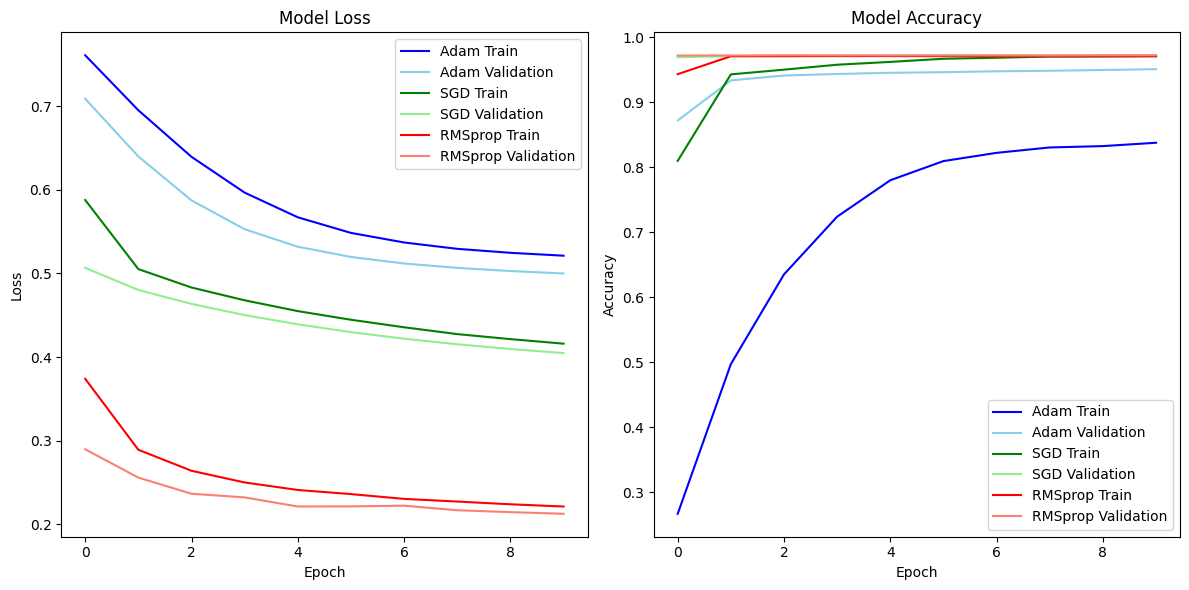

In [ ]:
# Plot training & validation loss for all three models
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(adam_history.history['loss'], label='Adam Train', color='blue')
plt.plot(adam_history.history['val_loss'], label='Adam Validation', color='skyblue')
plt.plot(sgd_history.history['loss'], label='SGD Train', color='green')
plt.plot(sgd_history.history['val_loss'], label='SGD Validation', color='lightgreen')
plt.plot(rmsprop_history.history['loss'], label='RMSprop Train', color='red')
plt.plot(rmsprop_history.history['val_loss'], label='RMSprop Validation', color='salmon')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Plot training & validation accuracy for all three models
plt.subplot(1, 2, 2)
plt.plot(adam_history.history['accuracy'], label='Adam Train', color='blue')
plt.plot(adam_history.history['val_accuracy'], label='Adam Validation', color='skyblue')
plt.plot(sgd_history.history['accuracy'], label='SGD Train', color='green')
plt.plot(sgd_history.history['val_accuracy'], label='SGD Validation', color='lightgreen')
plt.plot(rmsprop_history.history['accuracy'], label='RMSprop Train', color='red')
plt.plot(rmsprop_history.history['val_accuracy'], label='RMSprop Validation', color='salmon')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

In [ ]:
rmsprop_model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, None, 100)         600000    
                                                                 
 dropout_6 (Dropout)         (None, None, 100)         0         
                                                                 
 bidirectional_4 (Bidirecti  (None, None, 200)         160800    
 onal)                                                           
                                                                 
 dropout_7 (Dropout)         (None, None, 200)         0         
                                                                 
 bidirectional_5 (Bidirecti  (None, 200)               240800    
 onal)                                                           
                                                                 
 dropout_8 (Dropout)         (None, 200)              

In [ ]:
# Make predictions on the test data
y_pred = rmsprop_model.predict(X_test)
y_pred_binary = (y_pred > 0.5).astype(int)

# Extract true labels from the DataFrame
y_true = test[['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']].values

# Compute precision, recall, and F1-score for each label
precision_per_label = precision_score(y_true, y_pred_binary, average=None)
recall_per_label = recall_score(y_true, y_pred_binary, average=None)
f1_per_label = f1_score(y_true, y_pred_binary, average=None)

# Print precision, recall, and F1-score for each label
for label, precision, recall, f1 in zip(y.columns, precision_per_label, recall_per_label, f1_per_label):
    print(f"Label: {label}")
    print(f"Precision: {precision:.2f}")
    print(f"Recall: {recall:.2f}")
    print(f"F1-score: {f1:.2f}")
    print()

2000/2000 [==============================] - 18s 8ms/step
Label: toxic
Precision: 0.36
Recall: 0.90
F1-score: 0.52

Label: severe_toxic
Precision: 0.38
Recall: 0.02
F1-score: 0.04

Label: obscene
Precision: 0.60
Recall: 0.77
F1-score: 0.67

Label: threat
Precision: 0.00
Recall: 0.00
F1-score: 0.00

Label: insult
Precision: 0.54
Recall: 0.63
F1-score: 0.58

Label: identity_hate
Precision: 0.00
Recall: 0.00
F1-score: 0.00



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
rmsprop_model_evaluation = rmsprop_model.evaluate(X_test, y_test)

2000/2000 [==============================] - 18s 9ms/step - loss: 0.1260 - accuracy: 0.9976


**Define, train, and evaluate GRU model**

In [ ]:
# Define model
model1 = Sequential()
model1.add(Embedding(max_features, word_vector, weights=[embedding_matrix]))
model1.add(Dropout(0.5))
model1.add(Bidirectional(GRU(units=128, return_sequences=True)))
model1.add(Dropout(0.5))
model1.add(GRU(units=64))
model1.add(Dropout(0.2))
model1.add(Dense(6, activation='sigmoid'))

model1.compile(
    loss='binary_crossentropy',
    optimizer='rmsprop',
    metrics=['accuracy']
)

In [ ]:
# Start training
history1 = model1.fit(X_train, y, batch_size=64, epochs=10, validation_split=0.2)

Epoch 1/10
406/406 [==============================] - 44s 87ms/step - loss: 0.3264 - accuracy: 0.9251 - val_loss: 0.2530 - val_accuracy: 0.9721
Epoch 2/10
406/406 [==============================] - 17s 41ms/step - loss: 0.2595 - accuracy: 0.9580 - val_loss: 0.2254 - val_accuracy: 0.9721
Epoch 3/10
406/406 [==============================] - 12s 30ms/step - loss: 0.2399 - accuracy: 0.9617 - val_loss: 0.2187 - val_accuracy: 0.9716
Epoch 4/10
406/406 [==============================] - 11s 28ms/step - loss: 0.2291 - accuracy: 0.9620 - val_loss: 0.2081 - val_accuracy: 0.9715
Epoch 5/10
406/406 [==============================] - 9s 23ms/step - loss: 0.2205 - accuracy: 0.9623 - val_loss: 0.2017 - val_accuracy: 0.9715
Epoch 6/10
406/406 [==============================] - 9s 23ms/step - loss: 0.2154 - accuracy: 0.9617 - val_loss: 0.2007 - val_accuracy: 0.9716
Epoch 7/10
406/406 [==============================] - 10s 24ms/step - loss: 0.2084 - accuracy: 0.9600 - val_loss: 0.1937 - val_accuracy: 0

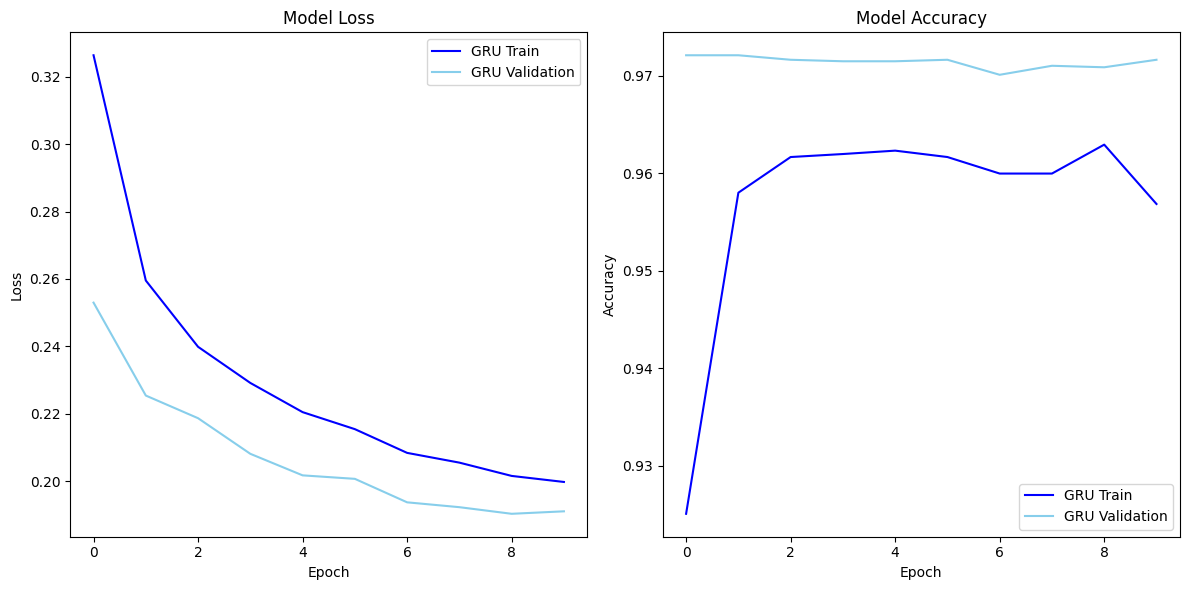

In [ ]:
# Plot training & validation loss
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history1.history['loss'], label='GRU Train', color='blue')
plt.plot(history1.history['val_loss'], label='GRU Validation', color='skyblue')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Plot training & validation accuracy
plt.subplot(1, 2, 2)
plt.plot(history1.history['accuracy'], label='GRU Train', color='blue')
plt.plot(history1.history['val_accuracy'], label='GRU Validation', color='skyblue')

plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

In [ ]:
# Evaluate the GRU model on the test data
y_pred_gru= model1.predict(X_test)
y_pred_binary = (y_pred_gru > 0.5).astype(int)

# Extract true labels from the DataFrame
y_true = test[['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']].values

# Compute precision, recall, and F1-score for each label
precision_per_label = precision_score(y_true, y_pred_binary, average=None)
recall_per_label = recall_score(y_true, y_pred_binary, average=None)
f1_per_label = f1_score(y_true, y_pred_binary, average=None)

# Print precision, recall, and F1-score for each label
for label, precision, recall, f1 in zip(y.columns, precision_per_label, recall_per_label, f1_per_label):
    print(f"Label: {label}")
    print(f"Precision: {precision:.2f}")
    print(f"Recall: {recall:.2f}")
    print(f"F1-score: {f1:.2f}")
    print()

2000/2000 [==============================] - 15s 7ms/step
Label: toxic
Precision: 0.39
Recall: 0.92
F1-score: 0.55

Label: severe_toxic
Precision: 0.40
Recall: 0.34
F1-score: 0.37

Label: obscene
Precision: 0.62
Recall: 0.74
F1-score: 0.67

Label: threat
Precision: 0.26
Recall: 0.19
F1-score: 0.22

Label: insult
Precision: 0.66
Recall: 0.59
F1-score: 0.62

Label: identity_hate
Precision: 0.61
Recall: 0.02
F1-score: 0.04



**Simple feed_forward model with TF-IDF features**

In [ ]:
# Get TF-IDF vectors
vectorizer = TfidfVectorizer(ngram_range=(1, 5), max_features=5000)
X_train_tf = vectorizer.fit_transform(train['masked_comment'])
X_test_tf = vectorizer.transform(test['comment_text'])
print(vectorizer)

TfidfVectorizer(max_features=5000, ngram_range=(1, 5))


In [ ]:
X_train_tf.shape

(32450, 5000)

In [ ]:
# Split the TF-IDF features and labels into training and validation sets
X_train_tf, X_val_tf, y_train, y_val = train_test_split(X_train_tf, y, test_size=0.2, random_state=42)

In [ ]:
# Learning Rate Scheduling
learning_rate = 0.0001
adam_epsilon = 1e-7

lr_schedule_1 = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=learning_rate,
    decay_steps=1000,
    decay_rate=0.95,
    staircase=True
)
# batch_size
batch_size = 64
# Epochs
epochs_1 = 15

def train_model(optimizer, X_train, y, X_val=None, y_val=None, batch_size=batch_size, epochs=epochs_1):
    # Create a new instance of the model
    model = Sequential()
    model.add(Dense(64, activation='relu', input_shape=(X_train.shape[1],)))
    model.add(Dropout(0.5))
    model.add(Dense(6, activation='sigmoid'))

    # Compile the model with the specified optimizer
    model.compile(
        loss='binary_crossentropy',
        optimizer=optimizer,
        metrics=['accuracy']
    )

    # Define validation data if provided
    validation_data = None
    if X_val is not None and y_val is not None:
        validation_data = (X_val, y_val)

    # Train the model
    history = model.fit(X_train, y, batch_size=batch_size, epochs=epochs, validation_data=validation_data)

    return model, history

# Train the model
# Convert sparse matrices to numpy arrays
X_train_tf_np = X_train_tf.toarray()
X_val_tf_np = X_val_tf.toarray()

# Convert Pandas DataFrame to numpy array
y_train_np = y_train.to_numpy()
y_val_np = y_val.to_numpy()
# Train the model
adam_model_tf, adam_history_tf = train_model(Adam(learning_rate=lr_schedule_1, epsilon=adam_epsilon), X_train_tf_np, y_train_np, X_val_tf_np, y_val_np)

Epoch 1/15
406/406 [==============================] - 5s 5ms/step - loss: 0.6111 - accuracy: 0.6702 - val_loss: 0.5157 - val_accuracy: 0.9723
Epoch 2/15
406/406 [==============================] - 2s 4ms/step - loss: 0.4535 - accuracy: 0.8993 - val_loss: 0.3936 - val_accuracy: 0.9723
Epoch 3/15
406/406 [==============================] - 2s 4ms/step - loss: 0.3753 - accuracy: 0.9365 - val_loss: 0.3415 - val_accuracy: 0.9723
Epoch 4/15
406/406 [==============================] - 2s 4ms/step - loss: 0.3374 - accuracy: 0.9385 - val_loss: 0.3114 - val_accuracy: 0.9723
Epoch 5/15
406/406 [==============================] - 2s 4ms/step - loss: 0.3133 - accuracy: 0.9399 - val_loss: 0.2910 - val_accuracy: 0.9723
Epoch 6/15
406/406 [==============================] - 3s 6ms/step - loss: 0.2949 - accuracy: 0.9406 - val_loss: 0.2763 - val_accuracy: 0.9723
Epoch 7/15
406/406 [==============================] - 2s 4ms/step - loss: 0.2821 - accuracy: 0.9366 - val_loss: 0.2645 - val_accuracy: 0.9723
Epoch 

In [ ]:
# Convert sparse matrices to numpy arrays
X_test_tf_np = X_test_tf.toarray()

# Evaluate the model on the test data
y_pred_tf = adam_model_tf.predict(X_test_tf_np)

# Binarize predictions if necessary
y_pred_binary = (y_pred_tf > 0.5).astype(int)

# Extract true labels from the DataFrame
y_true = y_test.values

# Compute precision, recall, and F1-score for each label
precision_per_label = precision_score(y_true, y_pred_binary, average=None)
recall_per_label = recall_score(y_true, y_pred_binary, average=None)
f1_per_label = f1_score(y_true, y_pred_binary, average=None)

# Print precision, recall, and F1-score for each label
for label, precision, recall, f1 in zip(y.columns, precision_per_label, recall_per_label, f1_per_label):
    print(f"Label: {label}")
    print(f"Precision: {precision:.2f}")
    print(f"Recall: {recall:.2f}")
    print(f"F1-score: {f1:.2f}")
    print()

2000/2000 [==============================] - 4s 2ms/step
Label: toxic
Precision: 0.40
Recall: 0.80
F1-score: 0.53

Label: severe_toxic
Precision: 0.39
Recall: 0.04
F1-score: 0.07

Label: obscene
Precision: 0.70
Recall: 0.56
F1-score: 0.63

Label: threat
Precision: 0.00
Recall: 0.00
F1-score: 0.00

Label: insult
Precision: 0.63
Recall: 0.51
F1-score: 0.57

Label: identity_hate
Precision: 0.00
Recall: 0.00
F1-score: 0.00



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
adam_model_tf_eva = adam_model_tf.evaluate(X_test_tf_np, y_test.values)

2000/2000 [==============================] - 5s 2ms/step - loss: 0.1286 - accuracy: 0.9976


In [ ]:
# Validify if rmsprop optimiser perform better
# batch_size
batch_size = 64
# Epochs
epochs_1 = 10

def train_model(optimizer, X_train, y, X_val=None, y_val=None, batch_size=batch_size, epochs=epochs_1):
    # Create a new instance of the model
    model = Sequential()
    model.add(Dense(64, activation='relu', input_shape=(X_train.shape[1],)))
    model.add(Dropout(0.5))
    model.add(Dense(6, activation='sigmoid'))

    # Compile the model with the specified optimizer
    model.compile(
        loss='binary_crossentropy',
        optimizer=optimizer,
        metrics=['accuracy']
    )

    # Define validation data if provided
    validation_data = None
    if X_val is not None and y_val is not None:
        validation_data = (X_val, y_val)

    # Train the model
    history = model.fit(X_train, y, batch_size=batch_size, epochs=epochs, validation_data=validation_data)

    return model, history

# Train the model
# Convert sparse matrices to numpy arrays
X_train_tf_np = X_train_tf.toarray()
X_val_tf_np = X_val_tf.toarray()

# Convert Pandas DataFrame to numpy array
y_train_np = y_train.to_numpy()
y_val_np = y_val.to_numpy()
# Train the model train_model(optimizer='rmsprop', X_train=X_train, y=y)
rmsprop_model_tf, rmsprop_history_tf = train_model(optimizer='rmsprop', X_train=X_train_tf_np, y=y_train_np, X_val=X_val_tf_np, y_val=y_val_np)

Epoch 1/10
406/406 [==============================] - 5s 5ms/step - loss: 0.3830 - accuracy: 0.9456 - val_loss: 0.2798 - val_accuracy: 0.9723
Epoch 2/10
406/406 [==============================] - 2s 4ms/step - loss: 0.2631 - accuracy: 0.9703 - val_loss: 0.2338 - val_accuracy: 0.9723
Epoch 3/10
406/406 [==============================] - 2s 6ms/step - loss: 0.2312 - accuracy: 0.9711 - val_loss: 0.2161 - val_accuracy: 0.9723
Epoch 4/10
406/406 [==============================] - 2s 4ms/step - loss: 0.2160 - accuracy: 0.9710 - val_loss: 0.2070 - val_accuracy: 0.9723
Epoch 5/10
406/406 [==============================] - 2s 4ms/step - loss: 0.2065 - accuracy: 0.9710 - val_loss: 0.2020 - val_accuracy: 0.9723
Epoch 6/10
406/406 [==============================] - 2s 5ms/step - loss: 0.1997 - accuracy: 0.9705 - val_loss: 0.1991 - val_accuracy: 0.9723
Epoch 7/10
406/406 [==============================] - 2s 4ms/step - loss: 0.1945 - accuracy: 0.9693 - val_loss: 0.1969 - val_accuracy: 0.9723
Epoch 

In [ ]:
# Convert sparse matrices to numpy arrays
X_test_tf_np = X_test_tf.toarray()

# Evaluate the model on the test data
y_pred_tf = rmsprop_model_tf.predict(X_test_tf_np)

# Binarize predictions
y_pred_binary = (y_pred_tf > 0.5).astype(int)

# Extract true labels from the DataFrame
y_true = y_test.values

# Compute precision, recall, and F1-score for each label
precision_per_label = precision_score(y_true, y_pred_binary, average=None)
recall_per_label = recall_score(y_true, y_pred_binary, average=None)
f1_per_label = f1_score(y_true, y_pred_binary, average=None)

# Print precision, recall, and F1-score for each label
for label, precision, recall, f1 in zip(y.columns, precision_per_label, recall_per_label, f1_per_label):
    print(f"Label: {label}")
    print(f"Precision: {precision:.2f}")
    print(f"Recall: {recall:.2f}")
    print(f"F1-score: {f1:.2f}")
    print()

2000/2000 [==============================] - 3s 2ms/step
Label: toxic
Precision: 0.40
Recall: 0.88
F1-score: 0.55

Label: severe_toxic
Precision: 0.36
Recall: 0.12
F1-score: 0.18

Label: obscene
Precision: 0.62
Recall: 0.74
F1-score: 0.68

Label: threat
Precision: 1.00
Recall: 0.01
F1-score: 0.02

Label: insult
Precision: 0.60
Recall: 0.66
F1-score: 0.63

Label: identity_hate
Precision: 0.00
Recall: 0.00
F1-score: 0.00



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
 # Define a test sentence
test_sentence = "Shit, this is not cool"

# Transform the test sentence using the same vectorizer
X_test_sentence_tf = vectorizer.transform([test_sentence])
X_test_sentence_np = X_test_sentence_tf.toarray()

# Predict using rmsprop_model
prediction = rmsprop_model_tf.predict(X_test_sentence_np)

# Convert the probability to a class
binary_prediction = 1 if np.max(prediction) > 0.5 else 0

print("Prediction:", binary_prediction)

1/1 [==============================] - 0s 30ms/step
Prediction: 1
